In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import glob
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

In [ ]:
#these options display all rows and columns in the dataframes. But they take a WHILE to load in colab
#pd.set_option('display.max_rows',None)
#pd.set_option('display.max_columns', None)

# 3. Data integration (extract)

In [ ]:
def extract() -> pd.DataFrame:

  """This functions combines all the csv, json, and parquet files into a dataframe

  Args:
  None: The function reads all csv, json, and parquet files in the working directory
  Returns:
  data (pd.DataFrame): All data sources combined in a single dataframe
  """

  columns = pd.read_csv('/content/ids_2.csv').columns #get columns from example file (example path in Collab: "/content/ids_2.csv")
  concatenated_dataframe = pd.DataFrame(columns=columns) #create an empty dataframe to hold all the data

  #glob.glob grabs all files in location that match its pattern. Here we use that to find csv, json, and parquet files.
  #FILES NEED TO BE UPLOADED TO COLLAB TO WORK
  for csvfile in glob.glob('/content/*.csv'):
    # load the current csv file into a temporary dataframe
    tmp_df = pd.read_csv(csvfile)
    # concatenate the loaded data with the data frame
    concatenated_dataframe = pd.concat([concatenated_dataframe, tmp_df], ignore_index=True)
  ## glob.glob('*.json')
  for jsonfile in glob.glob('/content/*.json'):
    # load the current json file into a temporary dataframe
    tmp_df = pd.read_json(jsonfile, lines=True)
    # concatenate the loaded data to the data frame
    concatenated_dataframe = pd.concat([concatenated_dataframe, tmp_df], ignore_index=True)
  for parquetfile in glob.glob('/content/*.parquet'):
    ## added this line after the data.parquet code so that this can be rerun later without causing the dataframe to double in size
    if parquetfile not in ['/content/data.parquet']:
      tmp_df = pd.read_parquet(parquetfile)
      concatenated_dataframe = pd.concat([concatenated_dataframe, tmp_df], ignore_index=True)


  # return the combined (extracted) data
  return concatenated_dataframe


In [ ]:
#FILES NEED TO BE UPLOADED TO COLLAB TO WORK. See discord thread
#Testing/Exploration : To be deleted
# Changed variable from 'df' to 'df_extracted' so that it can be referenced later

df_extracted = extract()

<ipython-input-3-0bcba181e6f4>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concatenated_dataframe = pd.concat([concatenated_dataframe, tmp_df], ignore_index=True)


# 4. Data Transformation (Transform)

In [ ]:

print(f'Total Duplicated Rows: {df_extracted.duplicated().sum()}')
print(f'Value Counts:')
print(df_extracted.value_counts())
print(df_extracted[' Label'].value_counts())
print(f"\nUnique Labels: {list(np.unique(df_extracted[' Label'].to_numpy(), return_counts=True)[0])}")
print('\n\nColumn Dtype List:\n')
for col in df_extracted.columns:
  print(f'\t"{col}" Dtype: {df_extracted[col].dtypes}')

Total Duplicated Rows: 12456
Value Counts:
 Destination Port   Flow Duration   Total Fwd Packets   Total Backward Packets  Total Length of Fwd Packets   Total Length of Bwd Packets   Fwd Packet Length Max   Fwd Packet Length Min   Fwd Packet Length Mean   Fwd Packet Length Std  Bwd Packet Length Max   Bwd Packet Length Min   Bwd Packet Length Mean   Bwd Packet Length Std  Flow Bytes/s   Flow Packets/s   Flow IAT Mean   Flow IAT Std   Flow IAT Max   Flow IAT Min  Fwd IAT Total   Fwd IAT Mean   Fwd IAT Std   Fwd IAT Max   Fwd IAT Min  Bwd IAT Total   Bwd IAT Mean   Bwd IAT Std   Bwd IAT Max   Bwd IAT Min  Fwd PSH Flags   Bwd PSH Flags   Fwd URG Flags   Bwd URG Flags   Fwd Header Length   Bwd Header Length  Fwd Packets/s   Bwd Packets/s   Min Packet Length   Max Packet Length   Packet Length Mean   Packet Length Std   Packet Length Variance  FIN Flag Count   SYN Flag Count   RST Flag Count   PSH Flag Count   ACK Flag Count   URG Flag Count   CWE Flag Count   ECE Flag Count   Down/Up Ratio

In [ ]:
# Drop Duplicates
df_extracted = df_extracted.drop_duplicates()

# "The last attack is not a denial of service, so the corresponding flows should be removed from the dataset. The DoS attacks should be grouped in a class labeled ‘attack.’"
# This is from the project description
df_removed_heartbleed = df_extracted[df_extracted[' Label'] != 'Heartbleed']

# Removing rows with NaNs, since there were only 6 of them
df_removed_nans = df_removed_heartbleed.dropna()

# Infinite values were causing an issue later down the line, and there were only like 2 of them
df_removed_infinite_values = df_removed_nans[df_removed_nans['Flow Bytes/s'] != np.inf]
df_removed_infinite_values = df_removed_infinite_values[df_removed_infinite_values[' Flow Packets/s'] != np.inf]

In [ ]:
#Moved Label Encoding(Categorical -> Integer) from step 7 to step 4
enc = OrdinalEncoder()
df_labels_binary_classification = df_removed_infinite_values[' Label'].to_numpy()
df_labels_binary_classification = enc.fit_transform(df_labels_binary_classification.reshape(-1,1))

#where function in numpy changes labels greater than 0 into 1 and leaves the benign labels as 0. so basically isthreat would be true or false
df_labels_binary_classification = np.where(df_labels_binary_classification > 0, 1, 0)

#checking the label names were converted successfully and that the amount of times they occur hasnt changed
label_dist = np.unique(df_labels_binary_classification, return_counts=True)
label_dist_dict = { newLabel:list(label_dist[1])[newLabel] for newLabel in list(label_dist[0])}
print(f'Label Distribution after encoding: \n{label_dist_dict}')

#update labels in dataset
df_removed_infinite_values[' Label'] = df_labels_binary_classification
df_transformed = df_removed_infinite_values

Label Distribution after encoding: 
{0: 4946, 1: 43709}


# 5. Data Storage (Load)

In [ ]:
def loadparquet(data: pd.DataFrame) -> None:
  data.to_parquet('data.parquet', compression='gzip')

In [ ]:
loadparquet(df_transformed)

# 6. Reading Data

In [ ]:
df_from_parquet = pd.read_parquet('data.parquet')

In [ ]:
#split labels and data
df_labels = df_from_parquet[' Label']
df_from_parquet = df_from_parquet.drop(' Label',axis=1)

# 7. Exploratory Data Analysis

In [ ]:
#identify shape of extracted dataset
#79 columns, 78 features + label
#48,672 rows
df_extracted.shape

(48672, 79)

In [ ]:
#unify the columns/feature names

In [ ]:
#checking out the number of labels and how often they occur
np.unique(df_labels, return_counts=True)

(array([0, 1]), array([ 4946, 43709]))

In [ ]:
#identify if uncleaned dataset has missing data
df_extracted.isna().sum().sum()
#data has 139 missing data values
# Missing values were removed previously

6

In [ ]:
#identify columns with a high percentage of missing data
df_extracted[['Flow Bytes/s',' Flow Packets/s']].isna().sum()
#flow bytes has 4 missing values and flow packets has 2

,0
Flow Bytes/s,4
Flow Packets/s,2


In [ ]:
#univariate analysis
df_from_parquet.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,48655.000000,4.865500e+04,48655.000000,48655.000000,48655.000000,4.865500e+04,48655.000000,48655.000000,48655.000000,48655.000000,...,48655.000000,48655.000000,4.865500e+04,4.865500e+04,4.865500e+04,4.865500e+04,4.865500e+04,4.865500e+04,4.865500e+04,4.865500e+04
mean,983.125290,4.900248e+07,6.183208,4.546069,440.640284,7.473161e+03,290.682828,6.495961,63.165675,116.589910,...,1.616709,29.203905,5.266250e+05,3.896007e+04,5.595913e+05,4.961034e+05,4.284349e+07,1.284799e+06,4.410341e+07,4.180401e+07
std,6648.036517,4.271803e+07,8.233331,11.800768,1857.463434,2.002611e+04,313.675877,60.914726,97.144281,117.853404,...,6.989370,5.962090,1.751486e+06,4.519535e+05,1.845932e+06,1.719454e+06,4.350711e+07,6.084353e+06,4.342476e+07,4.401214e+07
min,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,80.000000,9.629580e+06,4.000000,1.000000,69.500000,6.000000e+00,42.000000,0.000000,33.375000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,3.957375e+07,6.000000,5.000000,351.000000,1.159500e+04,340.000000,0.000000,51.000000,130.855923,...,1.000000,32.000000,8.820000e+02,0.000000e+00,8.820000e+02,8.730000e+02,1.870000e+07,0.000000e+00,3.200000e+07,8.023956e+06
75%,80.000000,9.804218e+07,8.000000,6.000000,410.000000,1.159500e+04,377.000000,0.000000,73.133929,162.366253,...,2.000000,32.000000,5.342000e+03,0.000000e+00,5.342000e+03,5.279500e+03,9.040000e+07,0.000000e+00,9.740000e+07,9.040000e+07
max,62011.000000,1.199989e+08,1235.000000,1881.000000,293115.000000,3.192321e+06,24820.000000,1983.000000,3731.837838,5185.441640,...,1233.000000,52.000000,1.370000e+07,9.587555e+06,1.950000e+07,1.370000e+07,1.200000e+08,6.080000e+07,1.200000e+08,1.200000e+08


In [ ]:
pd.set_option('display.max_rows', None)
df_from_parquet.var()

,0
Destination Port,4.419639e+07
Flow Duration,1.824830e+15
Total Fwd Packets,6.778774e+01
Total Backward Packets,1.392581e+02
Total Length of Fwd Packets,3.450170e+06
Total Length of Bwd Packets,4.010450e+08
Fwd Packet Length Max,9.839256e+04
Fwd Packet Length Min,3.710604e+03
Fwd Packet Length Mean,9.437011e+03
Fwd Packet Length Std,1.388942e+04


In [ ]:
df_from_parquet.shape

(48655, 78)

In [ ]:
X_clustering = df_from_parquet.copy()
y_clustering = df_labels

In [ ]:
# Removing outliers
# NOTE: THIS CODE MIGHT NOT BE HELPING MUCH
# NOTE: THIS CODE MIGHT NOT BE HELPING MUCH
# NOTE: THIS CODE MIGHT NOT BE HELPING MUCH
# NOTE: THIS CODE MIGHT NOT BE HELPING MUCH
from scipy.stats import zscore

z_scores = zscore(df_from_parquet)

threshold = 15

outliers = (z_scores > threshold) | (z_scores < -threshold)
actual_outliers = outliers[outliers.isin([True]).any(axis=1)]

In [ ]:
actual_outliers

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
83,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
86,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
106,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
127,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
133,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
141,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
174,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
175,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# NOTE: THIS CODE MIGHT NOT BE HELPING MUCH
# NOTE: THIS CODE MIGHT NOT BE HELPING MUCH
# NOTE: THIS CODE MIGHT NOT BE HELPING MUCH
# NOTE: THIS CODE MIGHT NOT BE HELPING MUCH
df_outliers_removed = df_from_parquet.copy()
df_labels_or = df_labels.copy()
for index, row in actual_outliers.iterrows():
  df_outliers_removed.drop(index)
  df_labels_or.drop(index)

In [ ]:
scaler = StandardScaler()
# X_clustering[X_clustering.columns] = scaler.fit_transform(X_clustering[X_clustering.columns], df_labels)
X_scaled = scaler.fit_transform(X_clustering)
#X_train_clustering[X_train_clustering.columns] = scaler.fit_transform(X_train_clustering[X_train_clustering.columns], df_labels)
#X_test_clustering[X_test_clustering.columns] = scaler.fit_transform(X_test_clustering[X_test_clustering.columns], df_labels)

In [ ]:
# Decided to just make a list of these to make things consistent and because I wanted a little break
graph_markers = ['o', 'v', 's', 'P', 'X', 'd', 'h', '+', '^', '$a$', '$b$', '$c$', '$d$', '$e$', '$f$', '$g$', '$h$', '$i$', '$j$', '$k$']
graph_colors = ['darkred', 'red', 'chocolate', 'peachpuff', 'orange', 'gold', 'yellow', 'olive', 'lime', 'teal', 'cyan', 'cadetblue', 'navy', 'blue', 'blueviolet', 'indigo', 'darkviolet', 'violet', 'magenta', 'deeppink', 'pink']

Text(0.5, 1.0, 'KMeans')

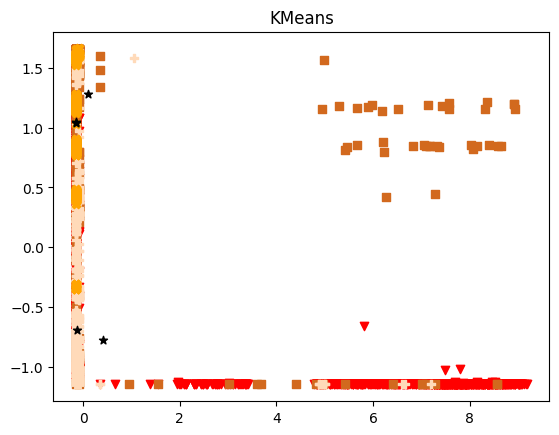

In [ ]:
#performing cluster analysis

kmeans = KMeans(n_clusters = 5, n_init='auto')
kmeans_pred = kmeans.fit_predict(X_scaled)

klabels = np.unique(kmeans_pred)
# print(klabels)

for i in klabels:
    plt.scatter(X_scaled[kmeans_pred==i, 0], X_scaled[kmeans_pred==i, 1], marker=graph_markers[i], color=graph_colors[i])
    # for j in X_train_clustering_2[kmeans_pred==i, 0]:
      # if j > 150:
        # print(X_train_clustering_2[kmeans_pred==i, 0])
        # print(i)
        # print([kmeans_pred==i, 0])
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', color='black')


plt.title("KMeans")

Text(0.5, 1.0, 'DBSCAN')

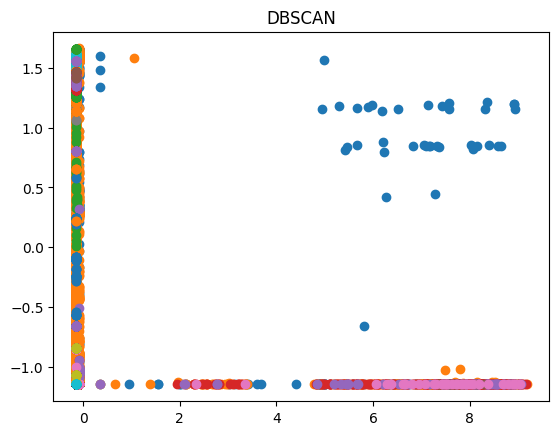

In [ ]:
db = DBSCAN(eps=5, min_samples=20, metric='euclidean')
db_pred = db.fit_predict(X_scaled)

dblabels = np.unique(db_pred)

# print(dblabels.size)

for i in dblabels:
    plt.scatter(
        X_scaled[db_pred==i, 0],
        X_scaled[db_pred==i, 1],
        # marker=graph_markers[i],
        # color=graph_colors[i]
    )


plt.title("DBSCAN")

# Notes:
# DBSCAN originally gave 164 clusters, which seemed really high
# min_samples=4, eps=1.4 -> 164
# 20, 1.4 -> 51


In [ ]:
#checking that the labels are either true or false and that the original counts havent changed
np.unique(df_labels, return_counts=True)

(array([0, 1]), array([ 4946, 43709]))

# 8. Data Preprocessing

In [ ]:
#Deduplicated, removed NaN values, and label encoding in step 4
df_from_parquet.head(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,53,194,2,2,66,386,33,33,33.000000,0.000000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,53,30883,2,2,66,150,33,33,33.000000,0.000000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
2,53,30865,2,2,88,210,44,44,44.000000,0.000000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
3,53,361,2,2,58,186,29,29,29.000000,0.000000,...,1,40,0.0,0.0,0,0,0.0,0.0,0,0
4,443,4255136,31,31,8010,62631,1163,0,258.387097,452.804496,...,9,32,0.0,0.0,0,0,0.0,0.0,0,0
5,53,30658,1,1,47,79,47,47,47.000000,0.000000,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
6,123,66024173,2,2,96,96,48,48,48.000000,0.000000,...,1,20,23974.0,0.0,23974,23974,66000000.0,0.0,66000000,66000000
7,443,567691,8,7,382,3788,201,0,47.750000,74.777288,...,7,20,0.0,0.0,0,0,0.0,0.0,0,0
8,50954,40,1,1,6,6,6,6,6.000000,0.000000,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
9,45099,51,1,1,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0


In [ ]:
X = df_from_parquet.copy()
y = df_labels
#Drop port as it should be irrelevant to the model
X = X.drop(' Destination Port', axis=1)

## 9. Feature Engineering

In [ ]:
#these are all the columns with under .1 variance.
low_variance_cols= X.columns[X.var() < 0.1].to_list()

high_variance_cols= [elem for elem in list(X.columns) if elem not in low_variance_cols]

df_columns_with_low_variance = X[low_variance_cols]
df_columns_with_high_variance = X[high_variance_cols]
print(f'Columns with low variance: {low_variance_cols}')
print(f'Columns with high variance: {high_variance_cols}')


Columns with low variance: ['Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' SYN Flag Count', ' RST Flag Count', ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
Columns with high variance: [' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', ' Fwd Header Length', ' Bwd Head

bivariate analysis

In [ ]:
df_columns_with_low_variance.corr()
#NaN correlation for most of the columns. indicates no change in values.

,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,SYN Flag Count,RST Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate
Fwd PSH Flags,1.000000,NaN,NaN,NaN,1.000000,-0.001113,0.307685,NaN,-0.001113,NaN,NaN,NaN,NaN,NaN,NaN
Bwd PSH Flags,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fwd URG Flags,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bwd URG Flags,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SYN Flag Count,1.000000,NaN,NaN,NaN,1.000000,-0.001113,0.307685,NaN,-0.001113,NaN,NaN,NaN,NaN,NaN,NaN
RST Flag Count,-0.001113,NaN,NaN,NaN,-0.001113,1.000000,-0.001280,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
URG Flag Count,0.307685,NaN,NaN,NaN,0.307685,-0.001280,1.000000,NaN,-0.001280,NaN,NaN,NaN,NaN,NaN,NaN
CWE Flag Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ECE Flag Count,-0.001113,NaN,NaN,NaN,-0.001113,1.000000,-0.001280,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Fwd Avg Bytes/Bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#correlation matrix
(X
.corr()
.style
.background_gradient(cmap='PRGn', vmin=-1, vmax=1)
)
#high correlation for the following features (above 90)
#Total Backward Packets and Total Fwd Packets, Flow IAT Max	Flow IAT, Fwd IAT Total, Fwd IAT Max, Idle Mean, Idle Max, Idle Min
#Flow duration and

In [ ]:
# Some code to check the highest correlations in the correlation matrix. Output of this function is correlations that are less than 1.0
c = X.corr().abs()

s = c.unstack()
sorted_correlation = s.sort_values(kind="quicksort")

sorted_correlation = sorted_correlation.dropna()

sorted_correlation_not_one = sorted_correlation[sorted_correlation < 1]
sorted_correlation_is_one = sorted_correlation[sorted_correlation == 1]

sorted_correlation_not_one.tail(150)

Bwd Header Length             Total Fwd Packets              0.922099
Subflow Fwd Packets            Bwd Header Length              0.922099
 Bwd Header Length            Subflow Fwd Packets             0.922099
 Total Fwd Packets             Bwd Header Length              0.922099
 Fwd IAT Mean                  Flow IAT Mean                  0.923182
 Flow IAT Mean                 Fwd IAT Mean                   0.923182
 Packet Length Std             Average Packet Size            0.923756
 Average Packet Size           Packet Length Std              0.923756
 Subflow Bwd Bytes            Subflow Fwd Packets             0.924013
                               Total Fwd Packets              0.924013
 Total Fwd Packets             Subflow Bwd Bytes              0.924013
                               Total Length of Bwd Packets    0.924013
 Total Length of Bwd Packets   Total Fwd Packets              0.924013
Subflow Fwd Packets            Subflow Bwd Bytes              0.924013
 Total Length of Bwd Packets  Subflow Fwd Packets             0.924013
Subflow Fwd Packets            Total Length of Bwd Packets    0.924013
 Active Max                    Active Min                     0.925269
 Active Min                    Active Max                     0.925269
Bwd IAT Total                  Bwd IAT Std                    0.926859
 Bwd IAT Std                  Bwd IAT Total                   0.926859
 Packet Length Std             Packet Length Mean             0.928948
 Packet Length Mean            Packet Length Std              0.928948
 Avg Bwd Segment Size          Bwd Packet Length Std          0.934698
 Bwd Packet Length Mean        Bwd Packet Length Std          0.934698
 Bwd Packet Length Std         Bwd Packet Length Mean         0.934698
                               Avg Bwd Segment Size           0.934698
 Packet Length Variance       Bwd Packet Length Max           0.935703
Bwd Packet Length Max          Packet Length Variance         0.935703
 Packet Length Variance        Packet Length Std              0.935963
 Packet Length Std             Packet Length Variance         0.935963
 Max Packet Length             Bwd Packet Length Mean         0.936719
 Bwd Packet Length Mean        Max Packet Length              0.936719
 Avg Bwd Segment Size          Max Packet Length              0.936719
 Max Packet Length             Avg Bwd Segment Size           0.936719
 Average Packet Size           Bwd Packet Length Mean         0.937697
 Avg Bwd Segment Size          Average Packet Size            0.937697
 Average Packet Size           Avg Bwd Segment Size           0.937697
 Bwd Packet Length Mean        Average Packet Size            0.937697
 Flow Duration                Idle Mean                       0.938118
Idle Mean                      Flow Duration                  0.938118
 Max Packet Length             Packet Length Variance         0.938136
 Packet Length Variance        Max Packet Length              0.938136
Idle Mean                     Fwd IAT Total                   0.938230
Fwd IAT Total                 Idle Mean                       0.938230
Bwd Packet Length Max          Avg Bwd Segment Size           0.941169
                               Bwd Packet Length Mean         0.941169
 Bwd Packet Length Mean       Bwd Packet Length Max           0.941169
 Avg Bwd Segment Size         Bwd Packet Length Max           0.941169
 Total Fwd Packets             Subflow Bwd Packets            0.945979
                               Total Backward Packets         0.945979
Subflow Fwd Packets            Total Backward Packets         0.945979
                               Subflow Bwd Packets            0.945979
 Subflow Bwd Packets           Total Fwd Packets              0.945979
 Total Backward Packets       Subflow Fwd Packets             0.945979
 Subflow Bwd Packets          Subflow Fwd Packets             0.945979
 Total Backward Packets        Total Fwd Packets              0.945979
 Avg Bwd Segment Size    

In [ ]:
# This shows all the 1.0 correlations. Note: this includes the main diagonal. Look at first column values with multiple results to see which ones are actual 1.0s
sorted_correlation_is_one

,,0
Idle Max,Idle Max,1.0
Flow Duration,Flow Duration,1.0
Bwd Packets/s,Bwd Packets/s,1.0
Idle Mean,Idle Mean,1.0
Flow IAT Std,Flow IAT Std,1.0
Flow IAT Max,Flow IAT Max,1.0
Flow IAT Min,Flow IAT Min,1.0
Fwd IAT Total,Fwd IAT Total,1.0
Fwd IAT Mean,Fwd IAT Mean,1.0
Fwd IAT Std,Fwd IAT Std,1.0


In [ ]:
df_columns_removed = df_columns_with_high_variance.copy(deep=True)
df_columns_removed.drop(columns=
 [
     ## 1.0 Correlation
     'Subflow Fwd Packets', ' Subflow Fwd Bytes', ' Subflow Bwd Packets', ' Subflow Bwd Bytes',
     ' Avg Bwd Segment Size', ' Avg Fwd Segment Size', ' Fwd Header Length.1',
     ## >.97
     ' Fwd IAT Max', ' Fwd IAT Max', ' Packet Length Mean', ' Idle Max',
     'Bwd Packet Length Max', ' Idle Min', ' Flow IAT Max', ' Packet Length Std',
     ' Bwd Packet Length Std', ' Flow Packets/s', ' Active Max', ' Subflow Bwd Bytes',
     ' Subflow Bwd Packets', ' Total Length of Bwd Packets', ' Bwd Header Length',
     ## >.94
     ' Bwd IAT Max', 'Init_Win_bytes_forward',

 ]
)
# Empty print statement here because otherwise it outputs a lot of unnecessary data
print()

Multivariate Analysis

In [ ]:
df_columns_removed.mean().to_frame().T

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,4.900248e+07,6.183208,4.546069,440.640284,7473.161463,290.682828,6.495961,63.165675,116.58991,3903.109115,...,1.616709,29.203905,526624.988823,38960.067428,559591.303915,496103.361299,4.284349e+07,1.284799e+06,4.410341e+07,4.180401e+07


In [ ]:
df_columns_removed.max().to_frame().T

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,119998924.0,1235.0,1881.0,293115.0,3192321.0,24820.0,1983.0,3731.837838,5185.44164,11632.0,...,1233.0,52.0,13700000.0,9587554.78,19500000.0,13700000.0,120000000.0,60800000.0,120000000.0,120000000.0


In [ ]:
X_train_before, X_test_before, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# We need to scale the data after train/test split, not before.

# # Scaling the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_before)
X_test_scaled = scaler.transform(X_test_before)

#Confirming Normalization
X_train_as_df = pd.DataFrame(X_train_scaled)
X_train_as_df.describe()


,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
count,3.892400e+04,3.892400e+04,3.892400e+04,38924.000000,3.892400e+04,3.892400e+04,3.892400e+04,3.892400e+04,3.892400e+04,3.892400e+04,...,3.892400e+04,3.892400e+04,3.892400e+04,3.892400e+04,3.892400e+04,3.892400e+04,3.892400e+04,3.892400e+04,3.892400e+04,3.892400e+04
mean,3.723942e-17,-2.646920e-17,2.628665e-17,0.000000,4.928747e-18,-6.608172e-17,1.898480e-17,1.058768e-17,1.359056e-16,-7.247083e-17,...,-1.533388e-17,-1.739665e-16,-3.833470e-17,-8.032032e-18,-2.948121e-17,-2.190554e-18,-1.533388e-17,2.081026e-17,2.774702e-17,-6.060533e-17
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,...,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-1.145391e+00,-6.084972e-01,-3.722345e-01,-0.223316,-3.565694e-01,-9.012651e-01,-1.038056e-01,-6.264300e-01,-9.603019e-01,-1.194439e+00,...,-2.238826e-01,-4.903282e+00,-3.005534e-01,-8.581267e-02,-3.029111e-01,-2.884222e-01,-9.830419e-01,-2.106865e-01,-1.013742e+00,-9.482185e-01
25%,-9.210441e-01,-2.563262e-01,-2.904348e-01,-0.189154,-3.562828e-01,-7.745700e-01,-1.038056e-01,-3.013872e-01,-9.603019e-01,-1.192595e+00,...,-8.526827e-02,-1.546226e+00,-3.005534e-01,-8.581267e-02,-3.029111e-01,-2.884222e-01,-9.830419e-01,-2.106865e-01,-1.013742e+00,-9.482185e-01
50%,-2.298718e-01,-2.154549e-02,3.676406e-02,-0.046978,1.973122e-01,1.493775e-01,-1.038056e-01,-1.240911e-01,1.138751e-01,1.401387e-01,...,-8.526827e-02,4.680076e-01,-3.000502e-01,-8.581267e-02,-3.024340e-01,-2.879152e-01,-5.531072e-01,-2.106865e-01,-2.767245e-01,-7.658421e-01
75%,1.147513e+00,2.132352e-01,1.185638e-01,-0.016835,1.973122e-01,2.668023e-01,-1.038056e-01,9.457405e-02,3.740451e-01,5.849979e-01,...,5.334609e-02,4.680076e-01,-2.975029e-01,-8.581267e-02,-3.000184e-01,-2.853488e-01,1.040755e+00,-2.106865e-01,1.229555e+00,1.052500e+00
max,1.663213e+00,1.442512e+02,1.534930e+02,147.033973,1.521374e+02,7.579565e+01,3.084607e+01,3.613136e+01,4.161278e+01,2.379181e+00,...,1.706876e+02,3.153652e+00,7.532931e+00,2.103186e+01,1.027034e+01,7.695090e+00,1.775898e+00,9.766675e+00,1.750074e+00,1.779259e+00


In [ ]:
# PCA
pcompnents = range(2, 57)
evrs = {n_components: sum(PCA(n_components=n_components).fit(X_train_scaled).explained_variance_ratio_) for n_components in pcompnents}


In [ ]:
evrs

{2: 0.3520389184772081,
 3: 0.4664374728512569,
 4: 0.5378867161971311,
 5: 0.6039879222521278,
 6: 0.6591117290334837,
 7: 0.7011815346115573,
 8: 0.7341860790822552,
 9: 0.7650871338712107,
 10: 0.7947477069814427,
 11: 0.8184372415417032,
 12: 0.8394060189967965,
 13: 0.8583483365230125,
 14: 0.8745596539535845,
 15: 0.8889806436344505,
 16: 0.9024674044470028,
 17: 0.9148835476899952,
 18: 0.9261583798929184,
 19: 0.9368993488346377,
 20: 0.9465604233364371,
 21: 0.9550031859161165,
 22: 0.9632458711842934,
 23: 0.970027655734134,
 24: 0.9761963022326355,
 25: 0.9807295960908955,
 26: 0.9851861230730118,
 27: 0.9883719459781504,
 28: 0.9909878024292348,
 29: 0.9932361690733196,
 30: 0.9948352471362149,
 31: 0.9958384908144376,
 32: 0.9967267050205512,
 33: 0.9974414980934972,
 34: 0.9978977833056297,
 35: 0.9982879548721051,
 36: 0.9986223283380601,
 37: 0.9989353651974854,
 38: 0.999205991008015,
 39: 0.9994615284459792,
 40: 0.9996606719042905,
 41: 0.9997589767668691,
 42: 0.999

In [ ]:
def n_component_selector(evrs: dict, early_stop_steps=3, early_stop_var=1e-3) -> int:
  steps=1
  max = [0,0]
  for key, value in evrs.items():
    if value-max[1] > early_stop_var:
      max = [key,value]
      steps=1
    else:
      steps+=1
    if steps > early_stop_steps:
      return max[0]

n_components = n_component_selector(evrs)
print(n_components)

pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

components=pca.components_

36


In [ ]:
X_train = X_train_pca
X_test = X_test_pca

# 10. Load Processed Data

In [ ]:
pd.DataFrame(X_train_pca).to_parquet('X_train_after_pca.parquet', compression='gzip')
pd.DataFrame(X_test_pca).to_parquet('X_test_after_pca.parquet', compression='gzip')


pd.DataFrame(X_train_scaled).to_parquet('X_train_before_pca.parquet', compression='gzip')
pd.DataFrame(X_train_scaled).head(20).to_csv('X_sample_20.csv',index=False)
pd.DataFrame(X_test_scaled).to_parquet('X_test_before_pca.parquet', compression='gzip')

pd.DataFrame(y_train).to_parquet('y_train.parquet', compression='gzip')
pd.DataFrame(y_test).to_parquet('y_test.parquet', compression='gzip')

# 11. Model Selection and Training

In [ ]:
from sklearn.metrics import f1_score,accuracy_score, confusion_matrix,ConfusionMatrixDisplay
import lightgbm as lgb
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm




/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 34945, number of negative: 3979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 38924, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.897775 -> initscore=2.172745
[LightGBM] [Info] Start training from score 2.172745
Training until validation scores don't improve for 50 rounds
[250]	valid_0's binary_logloss: 0.250867
[500]	valid_0's binary_logloss: 0.207855
[750]	valid_0's binary_logloss: 0.177264
[1000]	valid_0's binary_logloss: 0.153617
[1250]	valid_0's binary_logloss: 0.134466
[1500]	valid_0's binary_logloss: 0.118606
[1750]	valid_0's binary_logloss: 0.105243
[2000]	valid_0's binary_logloss: 0.0938956
[2250]	valid_0's binary_logloss: 0.0841426
[2500]	valid_0's binary_logloss: 0.0756635
[2750]	valid_0's binary_logl

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


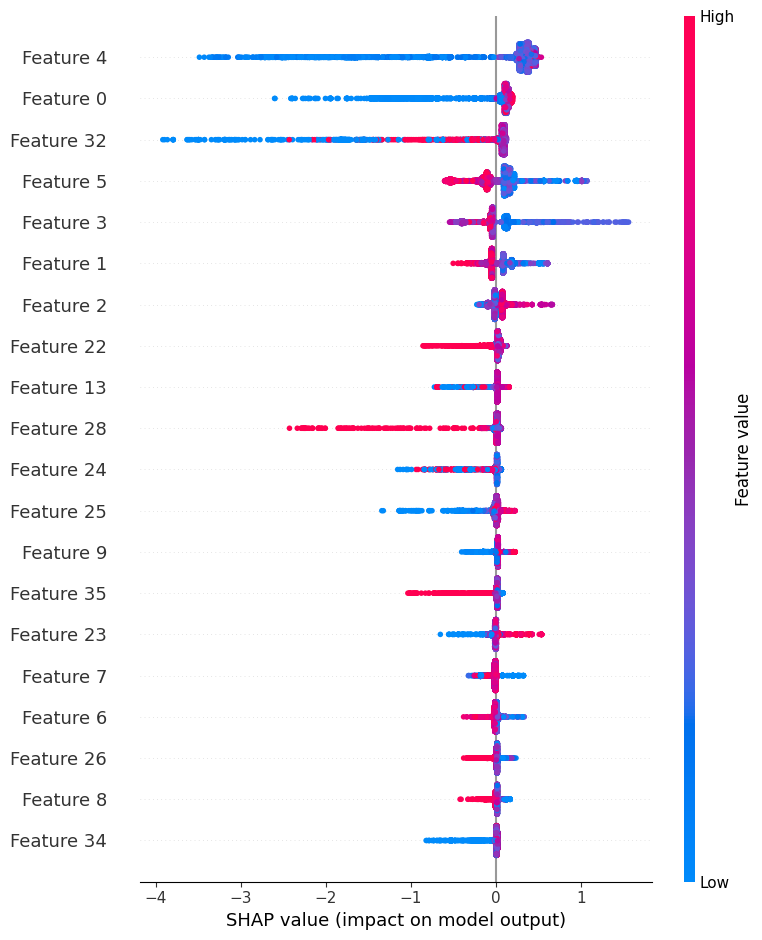

Confusion Matrix:


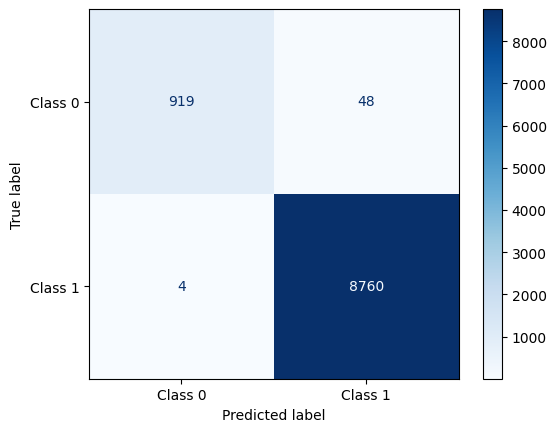

In [ ]:

config = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 17,
    "max_depth": 5,
    "learning_rate":5e-4,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.4,
    "bagging_freq": 1,
    "verbosity":1
}

lgb_model = lgb.train(
      params=config,
      train_set=lgb.Dataset(X_train, label=y_train),
      num_boost_round=5000,
      valid_sets=[lgb.Dataset(X_test, label=y_test)],
      callbacks=[
        lgb.early_stopping(stopping_rounds=50,verbose=True),lgb.log_evaluation(250)
      ],
)

y_pred_lgb = lgb_model.predict(X_test)

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

print("Confusion Matrix:")
y_pred_lgb = (y_pred_lgb > 0.5).astype(int)
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
labels = ['Class 0', 'Class 1']

disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=labels)
disp_lgb.plot(cmap=plt.cm.Blues)

plt.show()


Best hyperparameters: {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l1'}
Test accuracy: 0.9904
Confusion Matrix:


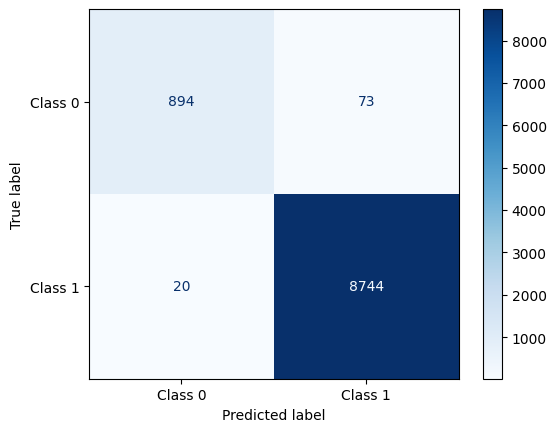

In [ ]:
svm = SGDClassifier(max_iter=200)

param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'loss': [ 'hinge']  # Loss function "hinge" implements a support vector machine
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")

best_svm = grid_search.best_estimator_
test_score = best_svm.score(X_test, y_test)
print(f"Test accuracy: {test_score:.4f}")

print("Confusion Matrix:")
y_pred_svm = best_svm.predict(X_test)
cm_svm=confusion_matrix(y_test, y_pred_svm)

disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=labels)
disp_svm.plot(cmap=plt.cm.Blues)

plt.show()

Best hyperparameters: {'alpha': 0.0001, 'loss': 'log_loss', 'penalty': 'l1'}
Test accuracy: 0.9897
Confusion Matrix:


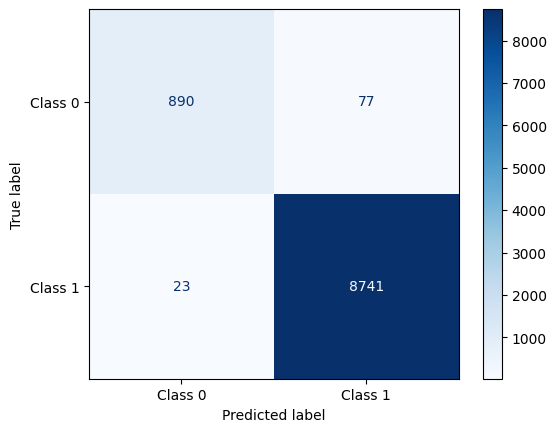

In [ ]:
logclass = SGDClassifier(max_iter=200,)

param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'loss': ['log_loss'] # Loss function "log_loss" implements logistic class
}

grid_search = GridSearchCV(estimator=logclass, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")

best_logclass = grid_search.best_estimator_
test_score = best_logclass.score(X_test, y_test)
print(f"Test accuracy: {test_score:.4f}")

print("Confusion Matrix:")
y_pred_logclass = best_logclass.predict(X_test)
cm_logclass =confusion_matrix(y_test, y_pred_logclass)

disp_logclass = ConfusionMatrixDisplay(confusion_matrix=cm_logclass, display_labels=labels)
disp_logclass.plot(cmap=plt.cm.Blues)

plt.show()


Training ...


  1%|▏         | 1/80 [00:06<07:58,  6.05s/it, loss=0.111]


NN Accuracy: 0.9843798170794369 



 14%|█▍        | 11/80 [01:11<07:28,  6.50s/it, loss=0.0233]


NN Accuracy: 0.9950673106566643 



 26%|██▋       | 21/80 [02:15<06:15,  6.37s/it, loss=0.0188]


NN Accuracy: 0.9950673106566643 



 39%|███▉      | 31/80 [03:20<05:17,  6.47s/it, loss=0.0171]


NN Accuracy: 0.9966087760764567 



 51%|█████▏    | 41/80 [04:24<04:08,  6.36s/it, loss=0.0164]


NN Accuracy: 0.9965060117151372 



 64%|██████▍   | 51/80 [05:25<02:56,  6.07s/it, loss=0.0161]


NN Accuracy: 0.9965060117151372 



 76%|███████▋  | 61/80 [06:27<01:59,  6.31s/it, loss=0.0157]


NN Accuracy: 0.9965060117151372 



 89%|████████▉ | 71/80 [07:29<00:55,  6.19s/it, loss=0.0181]


NN Accuracy: 0.9966087760764567 



100%|██████████| 80/80 [08:25<00:00,  6.31s/it, loss=0.0154]


Confusion Matrix:


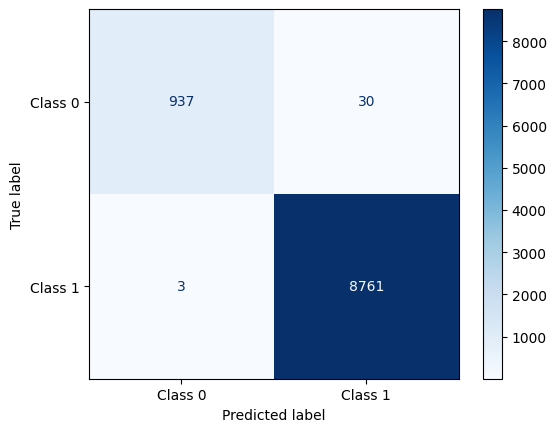

In [ ]:
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], 128),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

def train_pytorch_class(model, X_train, y_train, X_test, y_test, criterion, optimizer, epochs=50, batch_size=16):

    train_data = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                          torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)), batch_size=batch_size, shuffle=True)
    num_batches = len(train_data)
    model.train()
    print('Training ...')
    pbar=tqdm(range(epochs))
    #Display Progress Bar through tqdm
    for epoch in pbar:
      loss_total=0
      for X_batch, y_batch in train_data:
          optimizer.zero_grad()
          output = fc_nn(X_batch)
          loss = criterion(output, y_batch)
          loss.backward()
          optimizer.step()
          loss_total+=loss.item()
      loss_avg=loss_total/(num_batches)
      loss_total=0
      pbar.set_postfix({'loss': loss_avg})

      test_output = fc_nn(torch.tensor(X_test, dtype=torch.float32)).detach().numpy().round()

      if epoch % 10 == 0:
        print("\nNN Accuracy:", accuracy_score(y_test, test_output), "\n")





fc_nn = FullyConnectedNN()
criterion = nn.BCELoss()
optimizer = optim.AdamW(fc_nn.parameters(), lr=1e-4)
train_pytorch_class(fc_nn, X_train, y_train, X_test, y_test, criterion, optimizer, epochs=80)


print("Confusion Matrix:")
y_pred_fc_nn = fc_nn(torch.tensor(X_test, dtype=torch.float32)).detach().numpy().round()
cm_fc_nn = confusion_matrix(y_test, y_pred_fc_nn)

disp_fc_nn = ConfusionMatrixDisplay(confusion_matrix=cm_fc_nn, display_labels=labels)
disp_fc_nn.plot(cmap=plt.cm.Blues)

plt.show()


Training ...


  1%|▏         | 1/80 [00:03<04:44,  3.60s/it, loss=0.016]


NN Accuracy: 0.9964032473538177 



 14%|█▍        | 11/80 [00:42<04:23,  3.82s/it, loss=0.0151]


NN Accuracy: 0.9963004829924982 



 26%|██▋       | 21/80 [01:22<03:52,  3.95s/it, loss=0.0152]


NN Accuracy: 0.9964032473538177 



 39%|███▉      | 31/80 [02:01<03:17,  4.04s/it, loss=0.0151]


NN Accuracy: 0.9965060117151372 



 51%|█████▏    | 41/80 [02:39<02:26,  3.75s/it, loss=0.0154]


NN Accuracy: 0.9963004829924982 



 64%|██████▍   | 51/80 [03:18<01:51,  3.84s/it, loss=0.0151]


NN Accuracy: 0.9965060117151372 



 76%|███████▋  | 61/80 [03:58<01:14,  3.90s/it, loss=0.0151]


NN Accuracy: 0.9966087760764567 



 89%|████████▉ | 71/80 [04:37<00:36,  4.09s/it, loss=0.015]


NN Accuracy: 0.9965060117151372 



100%|██████████| 80/80 [05:12<00:00,  3.90s/it, loss=0.018]


Confusion Matrix:


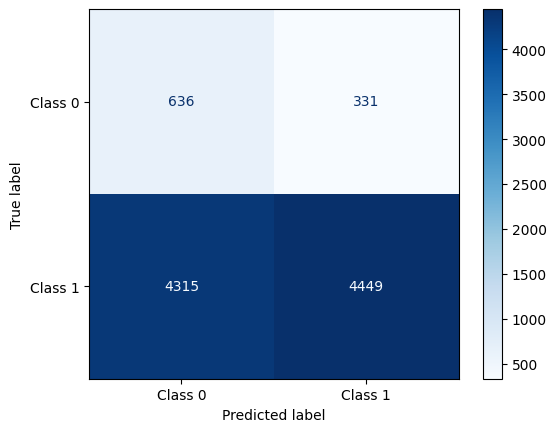

In [ ]:
class ShallowNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

shallow_nn = ShallowNN()
criterion = nn.BCELoss()
optimizer = optim.AdamW(shallow_nn.parameters(), lr=1e-4)
train_pytorch_class(shallow_nn, X_train, y_train, X_test, y_test, criterion, optimizer, epochs=80)


print("Confusion Matrix:")
y_pred_shallow_nn = shallow_nn(torch.tensor(X_test, dtype=torch.float32)).detach().numpy().round()
cm_shallow_nn = confusion_matrix(y_test, y_pred_shallow_nn)

disp_shallow_nn = ConfusionMatrixDisplay(confusion_matrix=cm_shallow_nn, display_labels=labels)
disp_shallow_nn.plot(cmap=plt.cm.Blues)

plt.show()


Model Evaluation

LGB Model

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [ ]:
acc_lgb_model = accuracy_score(y_test, y_pred_lgb)
f1score_lgb_model = f1_score(y_test, y_pred_lgb)
precision_lgb_model = precision_score(y_test, y_pred_lgb)
recall_lgb_model = recall_score(y_test, y_pred_lgb)
print('-'*25)
print('Light GBM Model')
print('-'*25)
print('Accuracy: {:.3f}'.format(acc_lgb_model))
print('Precision: {:.3f}'.format(precision_lgb_model))
print('Recall: {:.3f}'.format(recall_lgb_model))
print('F1-score: {:.3f}'.format(f1score_lgb_model))

-------------------------
Light GBM Model
-------------------------
Accuracy: 0.995
Precision: 0.995
Recall: 1.000
F1-score: 0.997


SVM




In [ ]:


acc_best_svm = accuracy_score(y_test, y_pred_svm)
f1score_best_svm = f1_score(y_test, y_pred_svm)
precision_best_svm = precision_score(y_test, y_pred_svm)
recall_best_svm = recall_score(y_test, y_pred_svm)
print('-'*25)
print('SVM Model')
print('-'*25)
print('Accuracy: {:.3f}'.format(acc_best_svm))
print('Precision: {:.3f}'.format(precision_best_svm))
print('Recall: {:.3f}'.format(recall_best_svm))
print('F1-score: {:.3f}'.format(f1score_best_svm))

-------------------------
SVM Model
-------------------------
Accuracy: 0.990
Precision: 0.992
Recall: 0.998
F1-score: 0.995


LOGCLASS

In [ ]:
acc_logclass = accuracy_score(y_test, y_pred_logclass)
f1score_logclass = f1_score(y_test, y_pred_logclass)
precision_logclass = precision_score(y_test, y_pred_logclass)
recall_logclass = recall_score(y_test, y_pred_logclass)
print('-'*25)
print('Log Class Model')
print('-'*25)
print('Accuracy: {:.3f}'.format(acc_logclass))
print('Precision: {:.3f}'.format(precision_logclass))
print('Recall: {:.3f}'.format(recall_logclass))
print('F1-score: {:.3f}'.format(f1score_logclass))

-------------------------
Log Class Model
-------------------------
Accuracy: 0.990
Precision: 0.991
Recall: 0.997
F1-score: 0.994


Fully Connected NN

In [ ]:

acc_fc_nn = accuracy_score(y_test, y_pred_fc_nn)
f1score_fc_nn = f1_score(y_test, y_pred_fc_nn)
precision_fc_nn = precision_score(y_test, y_pred_fc_nn)
recall_fc_nn = recall_score(y_test, y_pred_fc_nn)
print('-'*25)
print('Fully Connected Neural Network')
print('-'*25)
print('Accuracy: {:.3f}'.format(acc_fc_nn))
print('Precision: {:.3f}'.format(precision_fc_nn))
print('Recall: {:.3f}'.format(recall_fc_nn))
print('F1-score: {:.3f}'.format(f1score_fc_nn))

-------------------------
Fully Connected Neural Network
-------------------------
Accuracy: 0.997
Precision: 0.997
Recall: 1.000
F1-score: 0.998


Shallow Neural Network

In [ ]:

acc_shallow_nn = accuracy_score(y_test, y_pred_shallow_nn)
f1score_shallow_nn = f1_score(y_test, y_pred_shallow_nn)
precision_shallow_nn = precision_score(y_test, y_pred_shallow_nn)
recall_shallow_nn = recall_score(y_test, y_pred_shallow_nn)
print('-'*25)
print('Shallow Neural Network')
print('-'*25)
print('Accuracy: {:.3f}'.format(acc_shallow_nn))
print('Precision: {:.3f}'.format(precision_shallow_nn))
print('Recall: {:.3f}'.format(recall_shallow_nn))
print('F1-score: {:.3f}'.format(f1score_shallow_nn))

-------------------------
Shallow Neural Network
-------------------------
Accuracy: 0.523
Precision: 0.931
Recall: 0.508
F1-score: 0.657
